# Inverted pendulum on a cart
An easy example of controlling an _inverted pendulum on a cart_ from Steve Brunton book and YT lecture [1,2]. We consider _Euler–Lagrange equations_ as our pendulum model with the full nonlinear dynamics:

$\dot{x} = v$  
$\dot{v} = \frac{-m^2L^2 g cos(\theta)sin(\theta) + mL^2(mL\omega^2 \omega^2sin(\theta)-\delta v) +mL^2u}{mL^2(M+m(1-cos(\theta)^2))}$  
$\dot{\theta} = \omega$  
$\dot{\omega} = \frac{(m+M)mgLsin(\theta) - mLcos(\theta)(mL\omega^2sin(\theta)-\delta v) + mLcos(\theta)u}{mL^2(M+m(1-cos(\theta)^2))}$


This dynamics can be linarized into:  
$
\frac{d}{dt} \begin{bmatrix}
x_1\\
x_2\\
x_3\\
x_4
\end{bmatrix} = 
\begin{bmatrix}
0 & 1 & 0 & 0 \\
0 & -\frac{\omega}{M} & b\frac{mg}{M} & 0\\
0 & 0 & 0 & 1\\
0 & -b\frac{\delta}{ML} & -b\frac{(m + M)g}{ML} & 0
\end{bmatrix}
\begin{bmatrix}
x_1\\
x_2\\
x_3\\
x_4
\end{bmatrix}
+
\begin{bmatrix}
0\\
\frac{1}{M}\\
0\\
b\frac{1}{ML}
\end{bmatrix}
u
$,  
Where $m$ is pendulum mass, $M$ cart mass, $L$ pendulum length, $g$ gravitational acceleration, and $\delta$ cart damping. This system then represents matrix system:

$$\frac{dx}{dt} = Ax + Bu$$

In [1]:
import control
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

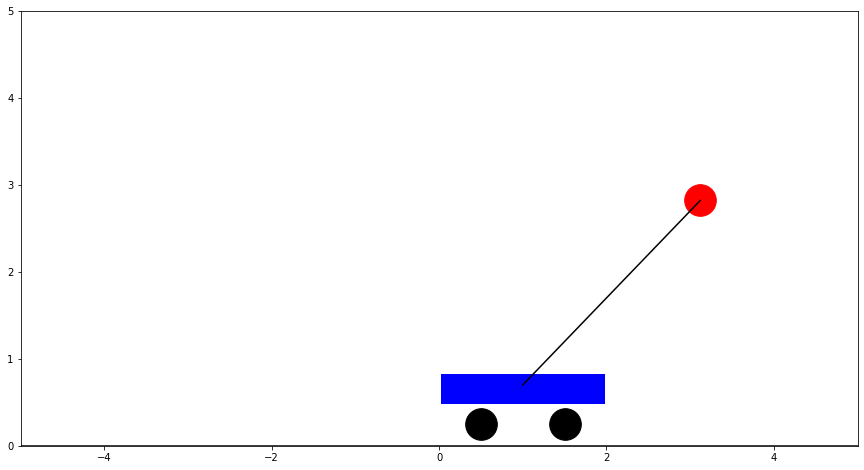

In [2]:
def cart(x=0, theta=np.pi, i=-1):
    plt.figure(figsize=(15, 8))
    plt.xlim(-5, 5)
    plt.ylim(0, 5)
    plt.scatter(-.5 + x, .25, s=1000, c="k")  # left wheel
    plt.scatter(.5 + x, .25, s=1000, c="k")  # right wheel
    plt.plot([-5, 5], [0, 0], "k-")  # x axis
    plt.plot([-.8 + x, .8 + x], [.65, .65], "b-", linewidth=30)  # cart body
    plt.plot([0 + x, -3 * np.sin(-theta) + x], [0.7, -3 * np.cos(-theta) + .7], "k-")  # pendulum arm
    plt.scatter(-3 * np.sin(-theta) + x, -3 * np.cos(-theta) + .7, s=1000, c="r")  # pendulum
    if i < 0:
        plt.show()
    else:
        plt.savefig(f"img/img_{i}.png", dpi=120, bbox_inches="tight")
    

cart(1, 3 * np.pi / 4)

In [3]:
def get_a_matrix(pend_mass=1, cart_mass=5, arm_length=2, g=-10, d=1, b=1):
    return np.array([
        [0, 1, 0, 0],
        [0, -d / cart_mass, b * pend_mass * g / cart_mass, 0],
        [0, 0, 0, 1],
        [0, -b * d / (cart_mass * arm_length), -b * (pend_mass + cart_mass) * g / (cart_mass * arm_length), 0]
    ])


def get_b_matrix(pend_mass=1, cart_mass=5, arm_length=2, g=-10, d=1, b=1):
    return np.array([[0, 1 / cart_mass, 0, b / (cart_mass * arm_length)]]).T

In [4]:
A = get_a_matrix()
B = get_b_matrix()
n = get_a_matrix().shape[0]

control_matrix = control.ctrb(A, B)
rank = np.linalg.matrix_rank(control_matrix)
print(f"Eigen values of matrix A: {list(np.linalg.eig(A)[0])}")
print(f"Rank of a control matrix C: rank={rank} (if rank={n} it is controllable)")

Eigen values of matrix A: [0.0, -2.4311230004720983, -0.23363938083350477, 2.464762381305604]
Rank of a control matrix C: rank=4 (if rank=4 it is controllable)


In [5]:
# Design LQR controller
Q = np.eye(4)   # np.diag(np.array([1, 1, 10, 100]))
R = .0001
K, S, E = control.lqr(A, B, Q, R)

In [6]:
def pendcart(x, t, pend_mass=1, cart_mass=5, arm_length=2, g=-10, d=1, s=1):
    Sx = np.sin(x[2])
    Cx = np.cos(x[2])
    D = pend_mass * (arm_length ** 2) * (pend_mass + cart_mass * (1 - Cx ** 2))
    
    wr = np.array([1, 0, np.pi, 0])
    
    u = np.dot(-K, (x - wr))[0]
    return np.array([
        x[1],
        (1/D)*(-(pend_mass**2)*(arm_length**2)*g*Cx*Sx+pend_mass*(arm_length**2)*(pend_mass*arm_length*(x[3]**2)*Sx-d*x[1]))+pend_mass*(arm_length**2)*(1/D)*u,
        x[3],
        (1/D)*((pend_mass+cart_mass)*pend_mass*g*arm_length*Sx-pend_mass*arm_length*Cx*(pend_mass*arm_length*(x[3]**2)*Sx-d*x[1]))-pend_mass*arm_length*Cx*(1/D)*u
    ])

Initial conditions:   
$x_0 = [-1, 0, \pi +  0.1, 0]^T$  
Actuation:   
$u = -K(x - w_r)$  
The reference position:  
$w_r = [1, 0, \pi, 0]^T$

In [7]:
t = np.arange(0, 10, 0.01)
x0 = np.array([-1, 0, np.pi + .1, 0])

sol = odeint(pendcart, x0, t)

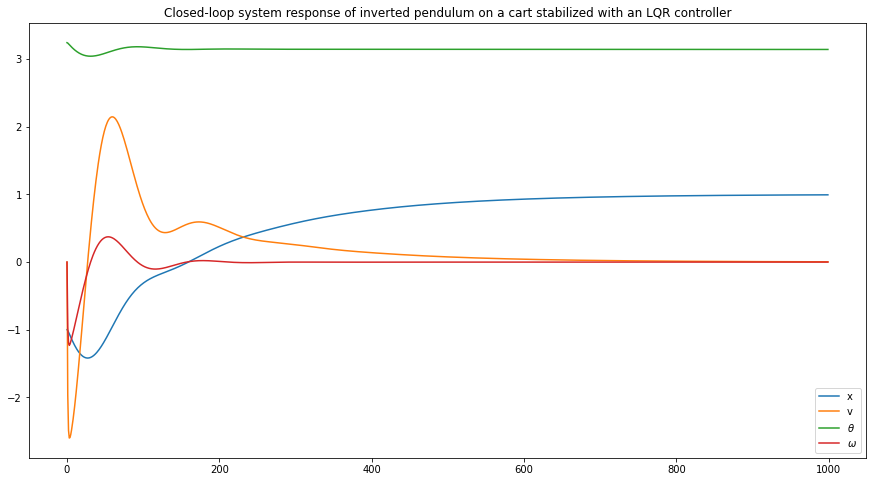

In [8]:
plt.figure(figsize=(15, 8))
plt.title("Closed-loop system response of inverted pendulum on a cart stabilized with an LQR controller")
plt.plot(sol, label=["x", "v", r"$\theta$", r"$\omega$"])
plt.legend()
plt.show()

In [ ]:
for i in range(len(t)):
    cart(sol[i][0], sol[i][2], i)

![](pendulum.gif)

## References
[1] Brunton, S., & Kutz, J. (2019). _Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control._ Cambridge: Cambridge University Press. doi:10.1017/9781108380690  
[2] Brunton, S, (2017). _Linear Quadratic Regulator (LQR) Control for the Inverted Pendulum on a Cart [Control Bootcamp]_, https://www.youtube.com/watch?v=1_UobILf3cc  